<a href="https://colab.research.google.com/github/Aayushktyagi/DeepLearning_Resources/blob/master/optimal_learning_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, History
from tensorflow.keras import backend as K

In [3]:
# Reproducibility is important
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format="svg"

In [5]:
class LRFinder(Callback):
    """
    Learning rate finder. This is a part of 1-cycle policy where we try to find the 
    optimal learning rate for training a model. 
    """
    def __init__(self, 
                 base_lr=1e-5,
                 max_lr=10,
                 beta=0.98,
                 scale_min_loss=None,
                 nb_steps=None,
                 clip_initial_values=None,
                 clip_end_values=None):
        """
        Arguments:
            base_lr: Initial learning rate. Can be as low as 1e-8
            
            max_lr:  Maximum learning rate to be considered for the test. Although `high learning rate` 
                     is a model dependent thing. For example, for a 3-layer network 0.1 can be a pretty high 
                     learning rate. A value between 2-10 is fine and if you wish you can run the learning rate 
                     test for more than one maximum value.
            
            beta:     Smoothening parameter for moving average of loss values. Better not to change the default value.
            nb_steps: Number of training steps/iterations in an epoch
            scale_min_loss: A value that is used to scale the minimum loss found yet to compare it with the
                            current loss. A value between 3-5 is found to be nominal 
            
            clip_initial_values: How many initial values to clip in the plots?
            clip_end_values: How many values to clip from the end in the plots?
        """
        super().__init__()
        assert nb_steps > 1, "Number of training steps should be greateer than 1"
        
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.beta = beta
        self.nb_steps = nb_steps
        self.min_loss = 0
        self.batch_num=0
        self.avg_loss=0
        self._lr_scaler = (max_lr / base_lr)**(1/(nb_steps-1))
        self.min_loss_scaler = scale_min_loss
        self.clip_initial_values = clip_initial_values
        self.clip_end_values = clip_end_values
        self.history = {}
    
    
    @property
    def lr_scaler(self):
        return (self.max_lr / self.base_lr)**(1/(self.nb_steps-1))
    
    
    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.batch_num == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
            
    def on_batch_begin(self, epoch, logs=None):
        self.batch_num+=1
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
    
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs["loss"]
        self.avg_loss = self.beta*self.avg_loss + (1-self.beta)*loss
        loss_smoothened = self.avg_loss/(1-self.beta**self.batch_num)
        
        if self.batch_num==1 or loss_smoothened < self.min_loss:
            self.min_loss = loss_smoothened
            
        self.history.setdefault('batch_loss', []).append(loss_smoothened)
        self.history.setdefault('lr', []).append(math.log10(self.base_lr))
        
        if self.min_loss_scaler:
            max_loss_check = self.min_loss_scaler*self.min_loss
        else:
            max_loss_check = 4*self.min_loss
            
        if self.batch_num>1 and (np.isnan(loss_smoothened) 
                                 or loss_smoothened > max_loss_check):
            print("LR range test complete")
            self.model.stop_training=True
            self.plot_values(self.history['lr'], self.history['batch_loss'])
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        self.base_lr*=self.lr_scaler
        K.set_value(self.model.optimizer.lr, self.base_lr)
        
    
    def plot_values(self,x,y):
        f,ax = plt.subplots(1,1, figsize=(8,5))
        if self.clip_initial_values:
            x = x[self.clip_initial_values:]
            y = x[self.clip_initial_values:]
        
        if self.clip_end_values:
            x = x[:self.clip_end_values]
            y = y[:self.clip_end_values]
        
        ax.plot(x, y)
        plt.title("LR_range test")
        plt.xlabel("Learning rate on log10 scale")
        plt.ylabel("Loss")
        plt.show()

In [6]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
# Pre-process the dataset
img_rows, img_columns, img_channels = 28,28,1
nb_classes=10

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Reshape the samples in the dataset as required by the model
x_train = x_train.reshape(x_train.shape[0], img_rows, img_columns, img_channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_columns, img_channels)

# convert class vectors to one hot-encoded vectors
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [8]:
def build_simple_model(input_shape, opt=None):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    if opt:
        opt = opt
    else:
        opt = SGD()
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [9]:
# Define batch size, number of epochs and number of training steps in an epoch
batch_size=32
nb_epochs =10
nb_steps = len(x_train)//batch_size
input_shape = (img_rows,img_columns,img_channels)

In [10]:
# Build the model
model = build_simple_model(input_shape)

# Train the model
model.fit(x_train, y_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 168s 89ms/step - loss: 0.5765 - accuracy: 0.8188
Epoch 2/10
1875/1875 [==============================] - 167s 89ms/step - loss: 0.2964 - accuracy: 0.9104
Epoch 3/10
1875/1875 [==============================] - 169s 90ms/step - loss: 0.2317 - accuracy: 0.9305
Epoch 4/10
1875/1875 [==============================] - 166s 89ms/step - loss: 0.1826 - accuracy: 0.9455
Epoch 5/10
1875/1875 [==============================] - 166s 88ms/step - loss: 0.1477 - accuracy: 0.9557
Epoch 6/10
1875/1875 [==============================] - 166s 89ms/step - loss: 0.1256 - accuracy: 0.9628
Epoch 7/10
1875/1875 [==============================] - 168s 90ms/step - loss: 0.1121 - accuracy: 0.9654
Epoch 8/10
1875/1875 [==============================] - 167s 89ms/step - loss: 0.0989 - accuracy: 0.9700
Epoch 9/10
1875/1875 [==============================] - 166s 88ms/step - loss: 0.0910 - accuracy: 0.9726
Epoch 10/10
1875/1875 [==============================] 

In [11]:
# What is the accuracy for this model?
score = model.evaluate(x_test, y_test, verbose=0, batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04657870903611183
Test accuracy: 0.9848999977111816


LR range test complete


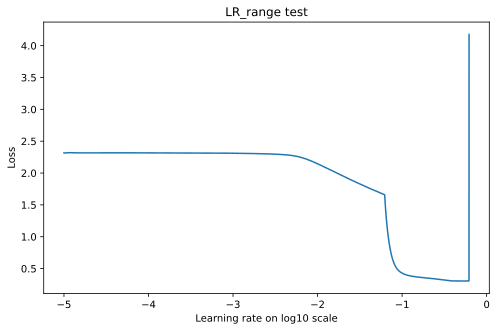

In [12]:
# Get an instance of LRTest class
lr_finder = LRFinder(nb_steps=nb_steps)

# Build the model again
model2 = build_simple_model(input_shape)

# Perform the LR range test 
history = model2.fit(x_train, y_train, epochs=nb_epochs, batch_size=batch_size, verbose=0, callbacks=[lr_finder])

Text(0.5, 0, 'Learning Rate')

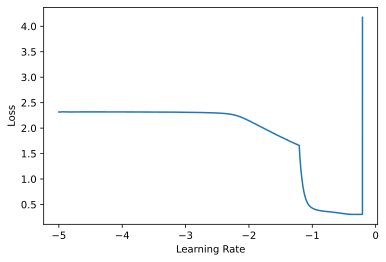

In [13]:
lrs, losses = (lr_finder.history["lr"], lr_finder.history["batch_loss"])
_, ax = plt.subplots(1,1)
ax.plot(lrs, losses)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
#ax.set_xscale('log10')
#ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))